# Echocardiogram data for classifying if patients will survive for at least one year after a heart attack

## Attribute Information
1. **survival** – Number of months a patient survived. Some patients may have survived less than a year but are still alive.
2. **still-alive** – Binary. 0=dead at end of survival period, 1=still alive.
3. **age-at-heart-attack** – Age when heart attack occurred.
4. **pericardial-effusion** – Binary. Indicates if there's fluid around the heart. 0=no fluid, 1=fluid.
5. **fractional-shortening** – Measure of heart contracility; lower numbers are more abnormal.
6. **epss** – E-point septal separation; larger numbers are more abnormal.
7. **lvdd** – Left ventricular end-diastolic dimension; indicates heart size at end-diastole.
8. **wall-motion-score** – Measure of left ventricle segment movement.
9. **wall-motion-index** – Wall-motion-score divided by number of segments seen in an echocardiogram.
10. **mult** – A derivative variable, can be ignored.
11. **name** – Patient's name.
12. **group** – To be ignored.
13. **alive-at-1** – Boolean. 0=dead after 1 year or followed for less than 1 year, 1=alive at 1 year. Derived from the first two attributes.

Dataset used: https://archive.ics.uci.edu/dataset/38/echocardiogram

## Questions

The study aims to address the following pertinent questions:

1. Is it possible to predict, with the given data, whether a patient will have a survival span exceeding one year?
2. Which variables or metrics can serve as reliable indicators of a patient's prospective lifetime?


## Import Libraries

In [72]:
import pandas as pd
import numpy as np

from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import PolynomialFeatures

import lifelines
from lifelines import CoxPHFitter
from lifelines import KaplanMeierFitter
from lifelines.statistics import proportional_hazard_test, logrank_test

import statsmodels.api as sm
from scipy.stats import shapiro

from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')


## Data Acquisition

1. The 50th row of the dataset contains incomplete data.
2. The original file lacks column headers, necessitating the inclusion of appropriate labels for clarity.
3. All instances of the '?' symbol should be replaced with 'Null' to maintain data integrity and consistency.

In [73]:
file_path = 'echocardiogram/'
file_name = 'echocardiogram.data'

column_names = ['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 'fractional-shortening', 
              'epss', 'lvdd', 'wall-motion-score', 'wall-motion-index', 'mult', 'name', 'group', 'alive-at-1']

echocardiogram_data = pd.read_csv(file_path + file_name, header=None, on_bad_lines='skip', decimal='.', na_values='?')

echocardiogram_data.columns = column_names

echocardiogram_data.head()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,name,group,alive-at-1
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,1.000,name,1.0,0.0
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.588,name,1.0,0.0
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,1.000,name,1.0,0.0
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.788,name,1.0,0.0
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.571,name,1.0,0.0


In [74]:
echocardiogram_data.describe()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,mult,group,alive-at-1
count,130.000000,131.000000,126.000000,131.000000,124.000000,117.000000,121.000000,128.000000,130.00000,128.000000,109.000000,74.000000
mean,22.182923,0.328244,62.813722,0.183206,0.216734,12.164769,4.763157,14.438125,1.37800,0.776719,1.779817,0.324324
std,15.858267,0.471377,8.342110,0.388320,0.107513,7.370159,0.810013,5.018566,0.45185,0.199078,0.416284,0.471317
min,0.030000,0.000000,35.000000,0.000000,0.010000,0.000000,2.320000,2.000000,1.00000,0.140000,1.000000,0.000000
25%,7.875000,0.000000,57.000000,0.000000,0.150000,7.000000,4.230000,11.000000,1.00000,0.713000,2.000000,0.000000
50%,23.500000,0.000000,62.000000,0.000000,0.205000,11.000000,4.650000,14.000000,1.21600,0.786000,2.000000,0.000000
75%,33.000000,1.000000,67.750000,0.000000,0.270000,16.100000,5.300000,16.500000,1.50750,0.857000,2.000000,1.000000
max,57.000000,1.000000,86.000000,1.000000,0.610000,40.000000,6.780000,39.000000,3.00000,2.000000,2.000000,1.000000


In [75]:
echocardiogram_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   survival               130 non-null    float64
 1   still-alive            131 non-null    int64  
 2   age-at-heart-attack    126 non-null    float64
 3   pericardial-effusion   131 non-null    int64  
 4   fractional-shortening  124 non-null    float64
 5   epss                   117 non-null    float64
 6   lvdd                   121 non-null    float64
 7   wall-motion-score      128 non-null    float64
 8   wall-motion-index      130 non-null    float64
 9   mult                   128 non-null    float64
 10  name                   131 non-null    object 
 11  group                  109 non-null    float64
 12  alive-at-1             74 non-null     float64
dtypes: float64(10), int64(2), object(1)
memory usage: 13.4+ KB


## Data Preparation

Some columns were unnecessary for analysis. Therefore, the columns 'mult', 'group', and 'name' were removed from further analysis.

In [76]:
columns_to_drop = ['mult', 'group', 'name']

echocardiogram_data_cleaned = echocardiogram_data.copy()

echocardiogram_data_cleaned = echocardiogram_data_cleaned.drop(columns=columns_to_drop)

echocardiogram_data_cleaned.head()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0


## Data Exploration and Analysis


In [77]:
profile = ProfileReport(echocardiogram_data_cleaned, title="Profiling Report")

profile.to_notebook_iframe()


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

### Data Integrity and Missing Values
In the initial data assessment, several inconsistencies were found in the dataset, specifically missing values in the following attributes:

1. age-at-heart-attack has 5 (3.8%) missing values
2. fractional-shortening has 7 (5.3%) missing values
3. epss has 14 (10.7%) missing values
4. lvdd has 10 (7.6%) missing values
5. wall-motion-score has 3 (2.3%) missing values
6. wall-motion-index has 1 (0.8%) missing value
7. alive-at-1 has 57 (43.5%) missing values
8. survival has 1 (0.8) missing value, which is crucial

**Note**: While techniques like SimpleImputer() can help fill in some missing values, a more thorough analysis is suggested before using these methods.

## survival

The survival attribute holds the most significance in the scope of this analysis. To maintain the integrity and relevance of the analysis, entries without this value will be excluded.


In [78]:
echocardiogram_data_cleaned = echocardiogram_data_cleaned.dropna(subset=['survival'])


### alive-at-1

Can be derived from first two variables: survival and still-alive

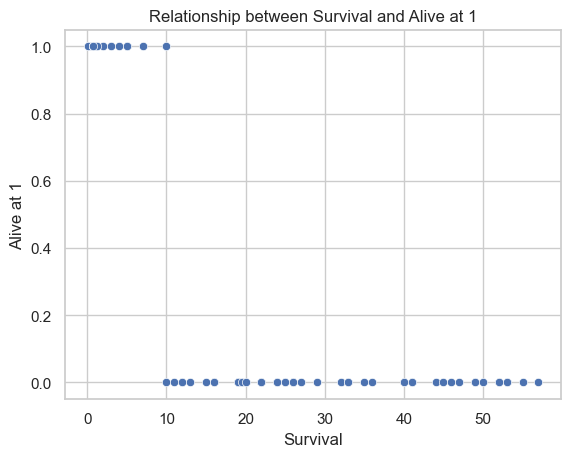

In [79]:
%matplotlib inline

sns.set(style="whitegrid") 

sns.scatterplot(x='survival', y='alive-at-1', data=echocardiogram_data_cleaned)

plt.xlabel('Survival')
plt.ylabel('Alive at 1')
plt.title('Relationship between Survival and Alive at 1')

plt.show()

# Let's create a new target variable for clearer analysis. The criteria are:

- 1 if survival is 12 or more
- 0 if survival is less than 12 and still-alive is 0
- Null if survival is less than 12 and still-alive is 1


In [80]:
def create_target(row):
    if row['survival'] >= 12:
        return 1
    elif row['survival'] < 12 and row['still-alive'] == 0:
        return 0
    elif row['survival'] < 12 and row['still-alive'] == 1:
        return np.NaN

echocardiogram_data_cleaned['target'] = echocardiogram_data_cleaned.apply(create_target, axis=1)

echocardiogram_data_cleaned.head()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,target
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0,0.0
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0,1.0
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0,1.0
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0,1.0
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0,1.0


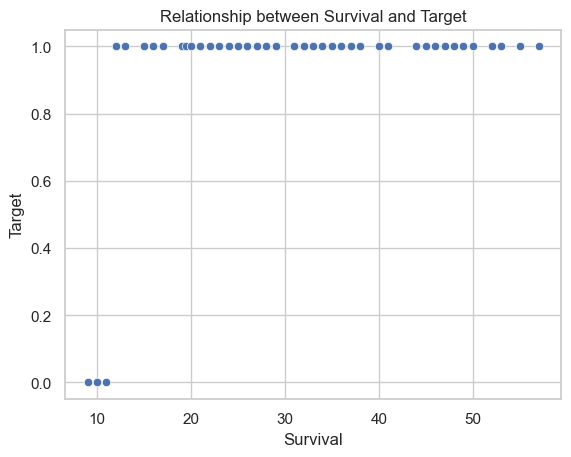

In [81]:
sns.scatterplot(x='survival', y='target', data=echocardiogram_data_cleaned)

plt.xlabel('Survival')
plt.ylabel('Target')
plt.title('Relationship between Survival and Target')

plt.show()


In [82]:
nan_count = echocardiogram_data_cleaned['target'].isna().sum()
true_count = echocardiogram_data_cleaned['target'].sum()
false_count = (echocardiogram_data_cleaned['target'] == False).sum()


total_rows = echocardiogram_data_cleaned.shape[0]

relative_nan_count = nan_count / total_rows
relative_true_count = true_count / total_rows
relative_false_count = false_count / total_rows

print(f"Relative number of NaN values in a new target column: {relative_nan_count:.2%}")
print(f"Relative number of true values in a new target column: {relative_true_count:.2%}")
print(f"Relative number of false values in a new target column: {relative_false_count:.2%}")


Relative number of NaN values in a new target column: 26.15%
Relative number of true values in a new target column: 70.77%
Relative number of false values in a new target column: 3.08%


A closer look at the alive-at-1 attribute revealed that 43.5% of the entries were missing, while only 3% were marked as 'dead before 1 year.' This imbalance can be problematic for standard classification algorithms, which often favor the majority class (survived) and misclassify the minority class (deceased). Given these issues, a more specialized approach is necessary, and survival analysis could be a good option for our dataset.

## epss & lvdd & fractional-shortening

### epss

We checked if the epss attribute follows a normal distribution to decide if we can fill in missing values with the mean. Here's what we found:

1. The epss values don't follow a normal distribution.
2. Over 10% of epss data is missing, which is significant given the sample size.
3. epss has a weak to moderate correlation with survival (-0.336), but stronger correlations with lvdd (0.553) and fractional-shortening (-0.455).

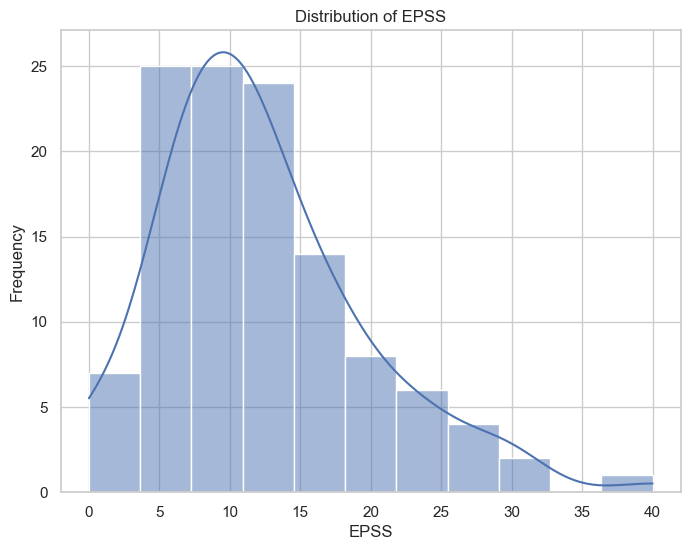

In [83]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_cleaned['epss'], kde=True)
plt.title('Distribution of EPSS')
plt.xlabel('EPSS')
plt.ylabel('Frequency')
plt.show()


In [84]:
p_value = shapiro(echocardiogram_data_cleaned['epss'].dropna())[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's EPSS values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's EPSS values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")

    

The data's EPSS values do not resemble a normal distribution (reject the hypothesis). p-value = 6.7e-05


In [85]:
epss_missing_values = echocardiogram_data_cleaned[echocardiogram_data_cleaned['lvdd'].isnull()]

epss_missing_values


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,target
27,29.00,0,55.0,0,NaN,7.0,NaN,2.0,1.00,NaN,1.0
28,0.25,1,75.0,0,NaN,NaN,NaN,NaN,1.00,NaN,NaN
32,3.00,1,NaN,0,NaN,12.0,NaN,6.0,3.00,NaN,NaN
34,35.00,0,63.0,0,NaN,10.0,NaN,14.0,1.17,0.0,1.0
37,1.00,1,65.0,0,0.06,23.6,NaN,21.5,2.15,1.0,NaN
45,37.00,0,64.0,0,0.09,NaN,NaN,12.0,2.00,NaN,1.0
46,19.50,1,81.0,0,0.12,NaN,NaN,9.0,1.25,0.0,1.0
48,0.25,1,63.0,1,NaN,NaN,NaN,23.0,2.30,1.0,NaN
50,7.00,1,61.0,1,0.27,NaN,NaN,9.0,1.50,1.0,NaN
83,0.75,1,61.0,0,NaN,NaN,NaN,28.0,2.33,1.0,NaN


## age-at-heart-attack

1. The age-at-heart-attack data is nearly normally distributed.
2. There is a 3.8% missing value rate, which is not too high but still important to note.
3. The variable has a weak correlation with both survival and still-alive attributes, with a coefficient of 0.229.

Based on these findings, we will replace the missing values in 'age-at-heart-attack' with the mean.


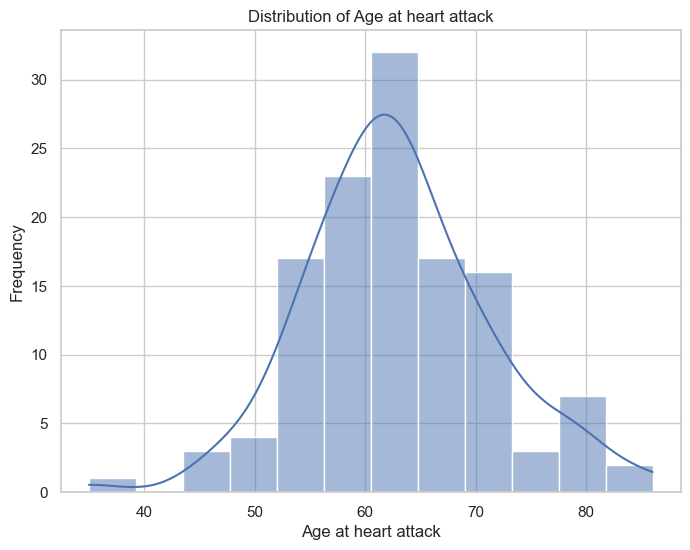

In [86]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_cleaned['age-at-heart-attack'], kde=True)
plt.title('Distribution of Age at heart attack')
plt.xlabel('Age at heart attack')
plt.ylabel('Frequency')
plt.show()


In [87]:
p_value = shapiro(echocardiogram_data_cleaned['age-at-heart-attack'].dropna())[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's Age at heart attack values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's Age at heart attack values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")

    

The data's Age at heart attack values resemble a normal distribution (do not reject the hypothesis). p-value = 0.13


In [88]:
mean_value = echocardiogram_data_cleaned['age-at-heart-attack'].mean()
echocardiogram_data_cleaned['age-at-heart-attack'].fillna(round(mean_value), inplace=True)


## wall-motion-score

1. The wall-motion-score data does not follow a normal distribution.
2. 2.3% of the data for this attribute is missing.
3. There is a weak negative correlation with 'survival' (-0.286) and a moderate positive correlation with the 'wall-motion-index' (0.608).

Since the data is not normally distributed, we suggest replacing the missing values in wall-motion-score with the median.


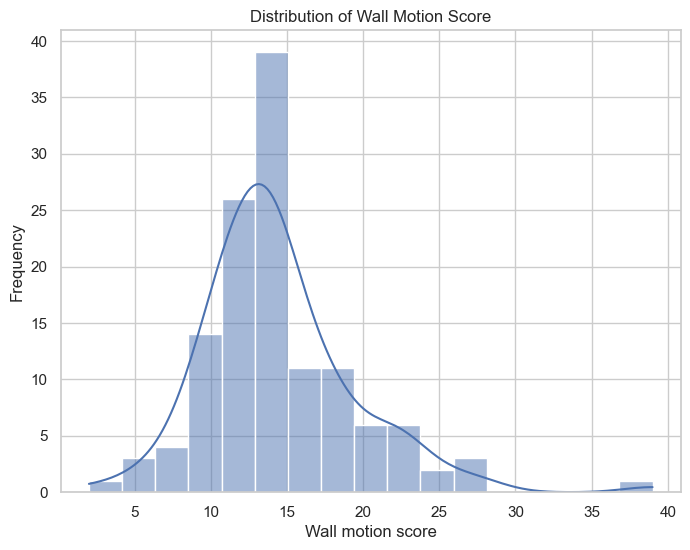

In [89]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_cleaned['wall-motion-score'], kde=True)
plt.title('Distribution of Wall Motion Score')
plt.xlabel('Wall motion score')
plt.ylabel('Frequency')

plt.show()


<Figure size 600x600 with 0 Axes>

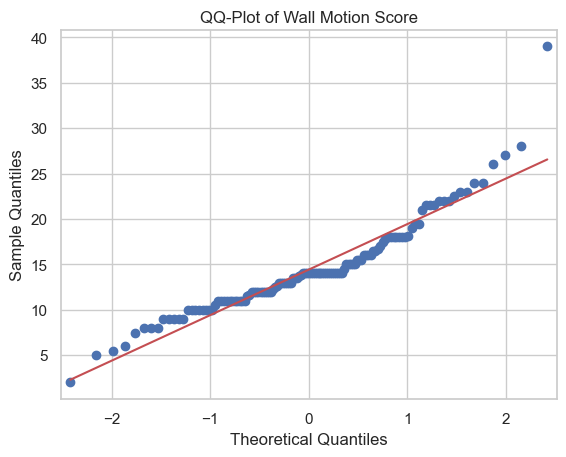

In [90]:
plt.figure(figsize=(6, 6))
sm.qqplot(echocardiogram_data_cleaned['wall-motion-score'].dropna(), line='s')
plt.title('QQ-Plot of Wall Motion Score')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


In [91]:
p_value = shapiro(echocardiogram_data_cleaned['wall-motion-score'].dropna())[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's Wall Motion Score values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's Wall Motion Score values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")
    

The data's Wall Motion Score values do not resemble a normal distribution (reject the hypothesis). p-value = 1e-06


Removing one outlier.

<Figure size 600x600 with 0 Axes>

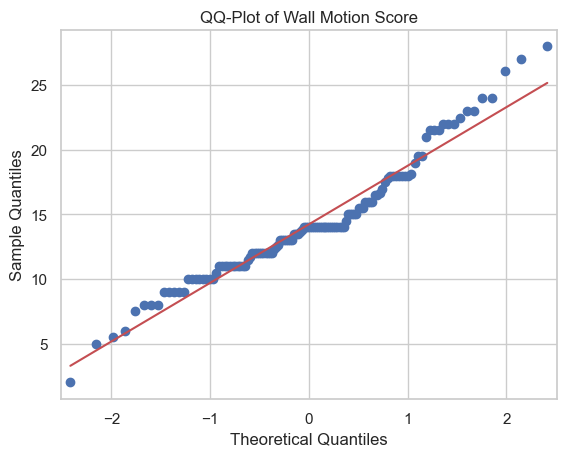

In [92]:
plt.figure(figsize=(6, 6))

upper_threshold = 35
data_without_outlier = echocardiogram_data_cleaned['wall-motion-score'].dropna()
data_without_outlier = data_without_outlier[data_without_outlier < upper_threshold] 

sm.qqplot(data_without_outlier, line='s')
plt.title('QQ-Plot of Wall Motion Score')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()


In [93]:
p_value = shapiro(data_without_outlier)[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's Wall Motion Score values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's Wall Motion Score values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")
    

The data's Wall Motion Score values do not resemble a normal distribution (reject the hypothesis). p-value = 0.00074


Key observations include:

1. The variable has weak correlations with important attributes in the dataset.
2. The amount of missing values is very low.

Based on these findings, it makes sense to replace the missing values in 'wall-motion-score' with the median.

In [94]:
median_value = echocardiogram_data_cleaned['wall-motion-score'].median()

echocardiogram_data_cleaned['wall-motion-score'].fillna(median_value, inplace=True)


## wall-motion-index

1. The wall-motion-index does not have a normal distribution; it is unimodal and right-skewed.
2. Only 0.8% of the data is missing.
3. There is a weak to moderate negative correlation with 'survival' (-0.323) and moderate correlations with 'wall-motion-score' (0.608) and 'epss' (0.391).

Since the distribution is right-skewed, we will replace the missing value in 'wall-motion-index' with the median.

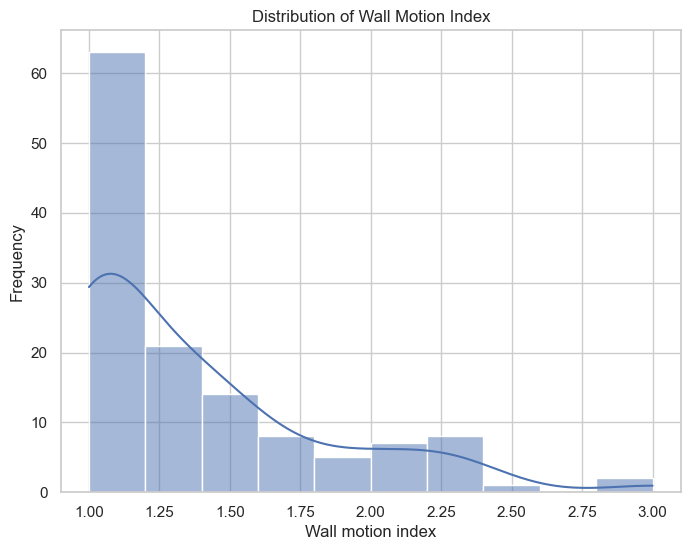

In [95]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_cleaned['wall-motion-index'], kde=True)
plt.title('Distribution of Wall Motion Index')
plt.xlabel('Wall motion index')
plt.ylabel('Frequency')
plt.show()


In [96]:
p_value = shapiro(echocardiogram_data_cleaned['wall-motion-index'].dropna())[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's Wall Motion Index values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's Wall Motion Index values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")


The data's Wall Motion Index values do not resemble a normal distribution (reject the hypothesis). p-value = 1.3e-11


In [97]:
median_value = echocardiogram_data_cleaned['wall-motion-index'].median()

echocardiogram_data_cleaned['wall-motion-index'].fillna(median_value, inplace=True)


In [98]:
missing_values_count = echocardiogram_data_cleaned.isnull().sum()

missing_values_table = pd.DataFrame({'Columns': missing_values_count.index, 'Number of missing values': missing_values_count.values})

missing_values_table


,Columns,Number of missing values
0,survival,0
1,still-alive,0
2,age-at-heart-attack,0
3,pericardial-effusion,0
4,fractional-shortening,7
5,epss,14
6,lvdd,10
7,wall-motion-score,0
8,wall-motion-index,0
9,alive-at-1,57


## Predictive Modeling for epss, lvdd, and fractional-shortening

To handle the missing values in the dataset, we suggest using a predictive modeling approach to estimate values for 'epss', 'lvdd', and 'fractional-shortening'.

We will begin with 'epss' because there is more data available for 'lvdd' and 'fractional-shortening' that can help predict the missing values for 'epss'.


### epss

In [99]:
echocardiogram_data_filled = echocardiogram_data_cleaned.copy().reset_index(drop=True)

data_cleaned = echocardiogram_data_filled.dropna(subset=['epss', 'lvdd'])

features_cleaned = data_cleaned.drop(['epss', 'alive-at-1', 'target', 'fractional-shortening'], axis=1)
target_epss_cleaned = data_cleaned['epss'].dropna()

features_cleaned = sm.add_constant(features_cleaned)

model_epss_cleaned = sm.OLS(target_epss_cleaned, features_cleaned).fit()

model_epss_cleaned.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   epss   R-squared:                       0.483
Model:                            OLS   Adj. R-squared:                  0.448
Method:                 Least Squares   F-statistic:                     13.88
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           1.37e-12
Time:                        20:16:10   Log-Likelihood:                -346.13
No. Observations:                 112   AIC:                             708.3
Df Residuals:                     104   BIC:                             730.0
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  -13.1716      5.422     -2.429      0.017     -23.924      -2.419
survival                -0.0298      0.046     -0.643      0.522      -0.122       0.062
still-alive              1.0250      1.678      0.611      0.543      -2.303       4.353
age-at-heart-attack     -0.0810      0.066     -1.235      0.220      -0.211       0.049
pericardial-effusion    -0.2000      1.373     -0.146      0.884      -2.923       2.523
lvdd                     5.1165      0.699      7.319      0.000       3.730       6.503
wall-motion-score        0.2299      0.168      1.367      0.175      -0.104       0.564
wall-motion-index        2.2257      1.921      1.158      0.249      -1.585       6.036
==============================================================================
Omnibus:                        7.570   Durbin-Watson:                   2.196
Prob(Omnibus):                  0.023   Jarque-Bera (JB):                9.484
Skew:                           0.362   Prob(JB):                      0.00872
Kurtosis:                       4.228   Cond. No.                         718.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

P>|t| shows 0.000 for lvdd and we saw the correlation before. 

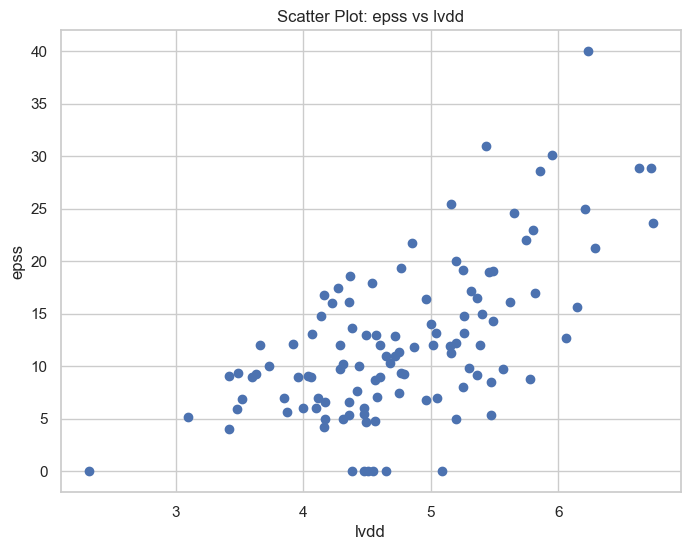

In [100]:
plt.figure(figsize=(8, 6))
plt.scatter(data_cleaned['lvdd'], data_cleaned['epss'])
plt.title('Scatter Plot: epss vs lvdd')
plt.xlabel('lvdd')
plt.ylabel('epss')
plt.show()


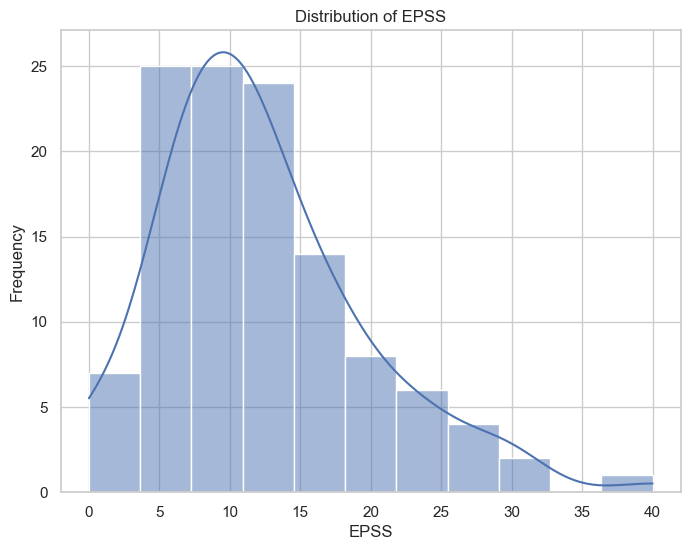

In [101]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['epss'], kde=True)
plt.title('Distribution of EPSS')
plt.xlabel('EPSS')
plt.ylabel('Frequency')
plt.show()


In [102]:
missing_epss_data = echocardiogram_data_filled[echocardiogram_data_filled['epss'].isnull()]

features_missing_epss = missing_epss_data[['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 
                                           'lvdd', 'wall-motion-score', 'wall-motion-index']]

features_missing_epss = sm.add_constant(features_missing_epss)

predicted_epss_missing = model_epss_cleaned.predict(features_missing_epss)

echocardiogram_data_filled.loc[echocardiogram_data_filled['epss'].isnull(), 'epss'] = round(predicted_epss_missing, 3)


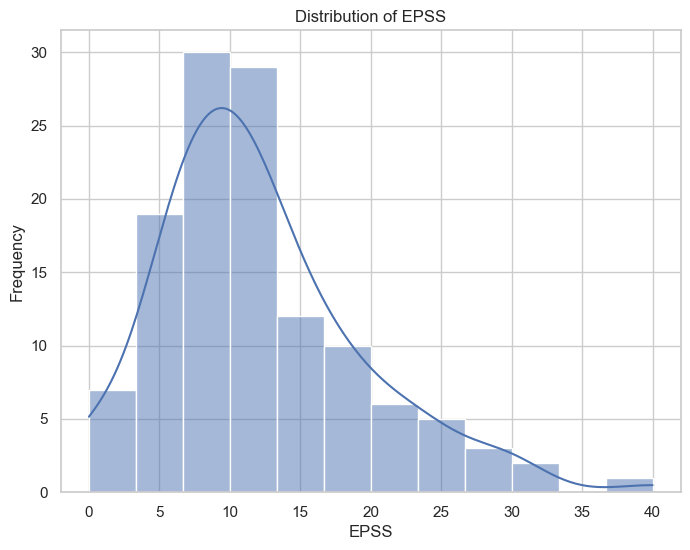

In [103]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['epss'], kde=True)
plt.title('Distribution of EPSS')
plt.xlabel('EPSS')
plt.ylabel('Frequency')
plt.show()


### lvdd

We'll replace missing values using OLS regression. We'll use the `ols` function from the `statsmodels` library to fit a linear regression model to the data.

In [104]:
lvdd_missing_values = echocardiogram_data_filled[echocardiogram_data_filled['lvdd'].isnull()]

lvdd_missing_values


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,target
27,29.00,0,55.0,0,NaN,7.0,NaN,2.0,1.00,NaN,1.0
28,0.25,1,75.0,0,NaN,NaN,NaN,14.0,1.00,NaN,NaN
32,3.00,1,63.0,0,NaN,12.0,NaN,6.0,3.00,NaN,NaN
34,35.00,0,63.0,0,NaN,10.0,NaN,14.0,1.17,0.0,1.0
37,1.00,1,65.0,0,0.06,23.6,NaN,21.5,2.15,1.0,NaN
45,37.00,0,64.0,0,0.09,NaN,NaN,12.0,2.00,NaN,1.0
46,19.50,1,81.0,0,0.12,NaN,NaN,9.0,1.25,0.0,1.0
48,0.25,1,63.0,1,NaN,NaN,NaN,23.0,2.30,1.0,NaN
50,7.00,1,61.0,1,0.27,NaN,NaN,9.0,1.50,1.0,NaN
83,0.75,1,61.0,0,NaN,NaN,NaN,28.0,2.33,1.0,NaN


In [105]:
data_cleaned = echocardiogram_data_filled.dropna(subset=['epss', 'lvdd'])

features_cleaned = data_cleaned.drop(['lvdd', 'alive-at-1', 'target', 'fractional-shortening'], axis=1)
target_lvdd_cleaned = data_cleaned['lvdd'].dropna()

features_cleaned = sm.add_constant(features_cleaned)

model_lvdd_cleaned = sm.OLS(target_lvdd_cleaned, features_cleaned).fit()

model_lvdd_cleaned.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   lvdd   R-squared:                       0.439
Model:                            OLS   Adj. R-squared:                  0.404
Method:                 Least Squares   F-statistic:                     12.52
Date:                Sat, 16 Nov 2024   Prob (F-statistic):           9.00e-12
Time:                        20:16:14   Log-Likelihood:                -109.88
No. Observations:                 120   AIC:                             235.8
Df Residuals:                     112   BIC:                             258.1
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    3.2905      0.530      6.206      0.000       2.240       4.341
survival                 0.0004      0.005      0.080      0.936      -0.010       0.010
still-alive              0.1059      0.181      0.584      0.560      -0.253       0.465
age-at-heart-attack      0.0124      0.007      1.709      0.090      -0.002       0.027
pericardial-effusion     0.0240      0.151      0.159      0.874      -0.274       0.323
epss                     0.0708      0.009      7.975      0.000       0.053       0.088
wall-motion-score       -0.0260      0.018     -1.414      0.160      -0.063       0.010
wall-motion-index        0.1369      0.214      0.638      0.525      -0.288       0.562
==============================================================================
Omnibus:                        1.992   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.369   Jarque-Bera (JB):                1.491
Skew:                           0.042   Prob(JB):                        0.475
Kurtosis:                       2.461   Cond. No.                         650.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

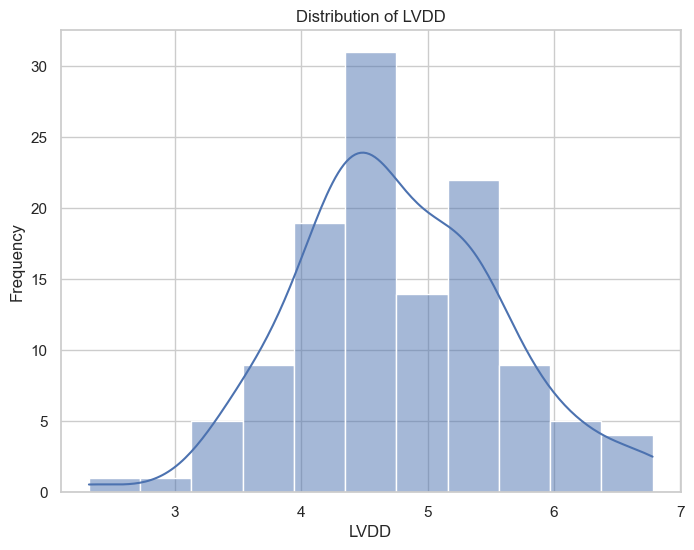

In [106]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['lvdd'], kde=True)
plt.title('Distribution of LVDD')
plt.xlabel('LVDD')
plt.ylabel('Frequency')
plt.show()


In [107]:
missing_lvdd_data = echocardiogram_data_filled[echocardiogram_data_filled['lvdd'].isnull()]

features_missing_lvdd = missing_lvdd_data[['survival', 'still-alive', 'age-at-heart-attack', 'pericardial-effusion', 
                                           'epss', 'wall-motion-score', 'wall-motion-index']]

features_missing_lvdd = sm.add_constant(features_missing_lvdd)

predicted_lvdd_missing = model_lvdd_cleaned.predict(features_missing_lvdd)

echocardiogram_data_filled.loc[echocardiogram_data_filled['lvdd'].isnull(), 'lvdd'] = round(predicted_lvdd_missing, 3)


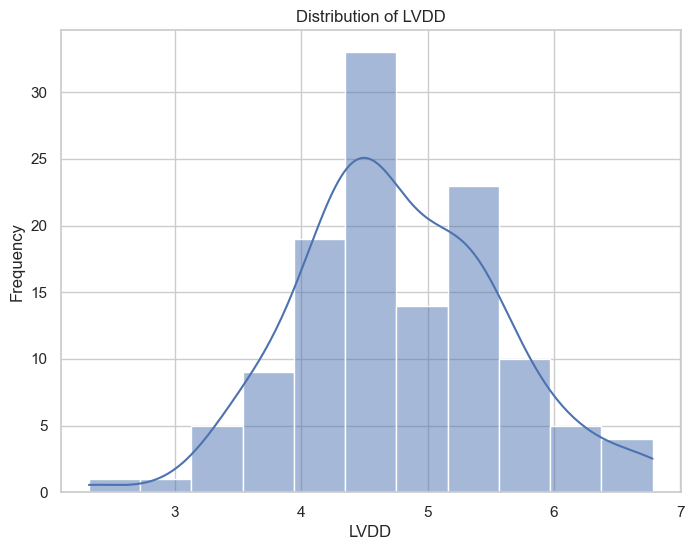

In [108]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['lvdd'], kde=True)
plt.title('Distribution of LVDD')
plt.xlabel('LVDD')
plt.ylabel('Frequency')
plt.show()


### Replace left missing with median values

In [109]:
median_value = echocardiogram_data_filled['epss'].median()

echocardiogram_data_filled['epss'].fillna(round(median_value, 3), inplace=True)


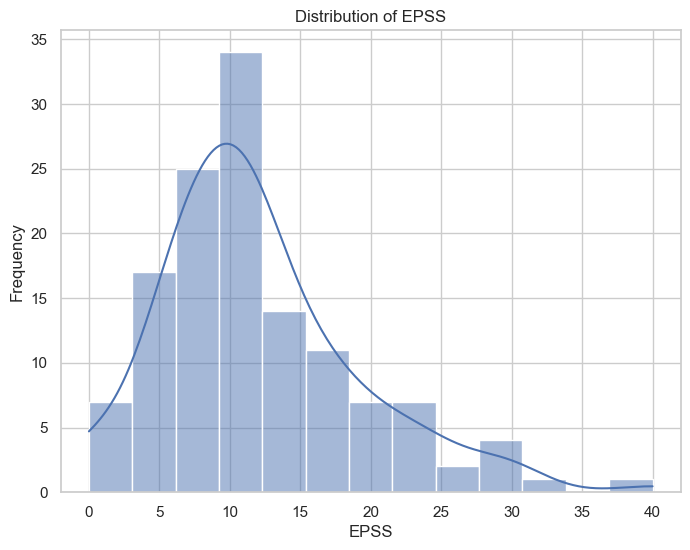

In [110]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['epss'], kde=True)
plt.title('Distribution of EPSS')
plt.xlabel('EPSS')
plt.ylabel('Frequency')
plt.show()


In [111]:
median_value = echocardiogram_data_filled['lvdd'].median()

echocardiogram_data_filled['lvdd'].fillna(round(median_value, 3), inplace=True)

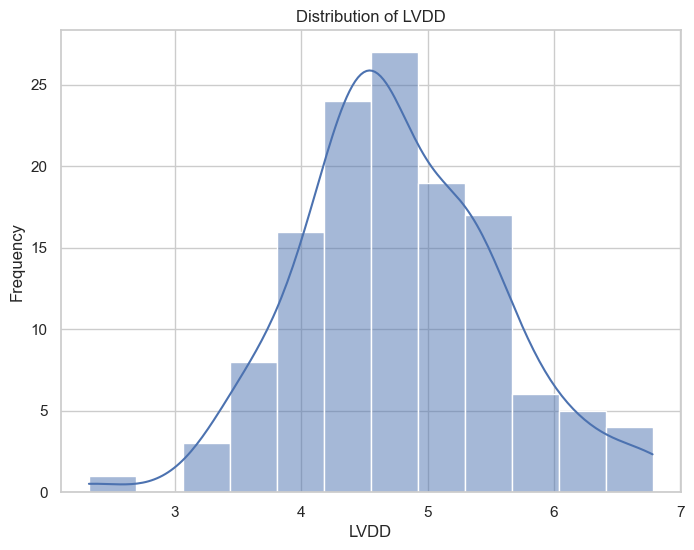

In [112]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['lvdd'], kde=True)
plt.title('Distribution of LVDD')
plt.xlabel('LVDD')
plt.ylabel('Frequency')
plt.show()


### fractional-shortening 

In [113]:
fractional_shortening_missing_values = echocardiogram_data_filled[echocardiogram_data_filled['fractional-shortening'].isnull()]

fractional_shortening_missing_values


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,target
27,29.00,0,55.0,0,NaN,7.000,4.562,2.0,1.00,NaN,1.0
28,0.25,1,75.0,0,NaN,10.650,4.665,14.0,1.00,NaN,NaN
32,3.00,1,63.0,0,NaN,12.000,5.280,6.0,3.00,NaN,NaN
34,35.00,0,63.0,0,NaN,10.000,4.586,14.0,1.17,0.0,1.0
36,16.00,0,63.0,1,NaN,11.594,5.310,5.0,1.00,0.0,1.0
48,0.25,1,63.0,1,NaN,10.650,4.665,23.0,2.30,1.0,NaN
83,0.75,1,61.0,0,NaN,10.650,4.665,28.0,2.33,1.0,NaN


In [114]:
data_cleaned = echocardiogram_data_filled.dropna(subset=['fractional-shortening', 'epss', 'lvdd'])

features_cleaned = data_cleaned.drop(['fractional-shortening', 'alive-at-1', 'target'], axis=1)
target_fractional_shortening_cleaned = data_cleaned['fractional-shortening'].dropna()

features_cleaned = sm.add_constant(features_cleaned)

model_fractional_shortening_cleaned = sm.OLS(target_fractional_shortening_cleaned, features_cleaned).fit()

model_fractional_shortening_cleaned.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                              OLS Regression Results                             
=================================================================================
Dep. Variable:     fractional-shortening   R-squared:                       0.193
Model:                               OLS   Adj. R-squared:                  0.137
Method:                    Least Squares   F-statistic:                     3.418
Date:                   Sat, 16 Nov 2024   Prob (F-statistic):            0.00147
Time:                           20:16:18   Log-Likelihood:                 113.01
No. Observations:                    123   AIC:                            -208.0
Df Residuals:                        114   BIC:                            -182.7
Df Model:                              8                                         
Covariance Type:               nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                    0.3811      0.098      3.898      0.000       0.187       0.575
survival                 0.0002      0.001      0.204      0.839      -0.001       0.002
still-alive             -0.0377      0.029     -1.306      0.194      -0.095       0.020
age-at-heart-attack      0.0002      0.001      0.130      0.897      -0.002       0.002
pericardial-effusion     0.0141      0.024      0.582      0.562      -0.034       0.062
epss                    -0.0024      0.002     -1.360      0.177      -0.006       0.001
lvdd                    -0.0246      0.015     -1.625      0.107      -0.055       0.005
wall-motion-score        0.0007      0.003      0.235      0.815      -0.005       0.006
wall-motion-index       -0.0233      0.033     -0.710      0.479      -0.088       0.042
==============================================================================
Omnibus:                       12.695   Durbin-Watson:                   1.753
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               15.442
Skew:                           0.611   Prob(JB):                     0.000443
Kurtosis:                       4.232   Cond. No.                         761.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

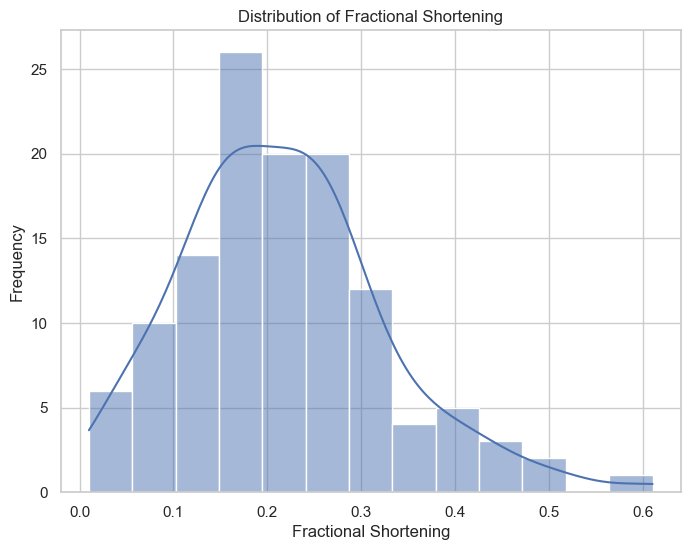

In [115]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['fractional-shortening'], kde=True)
plt.title('Distribution of Fractional Shortening')
plt.xlabel('Fractional Shortening')
plt.ylabel('Frequency')
plt.show()


In [116]:
p_value = shapiro(echocardiogram_data_filled['fractional-shortening'].dropna())[1]

alpha = 0.05
if p_value > alpha:
    print(f"The data's Fractional Shortening values resemble a normal distribution (do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data's Fractional Shortening values do not resemble a normal distribution (reject the hypothesis). p-value = {p_value:.2}")
    

The data's Fractional Shortening values do not resemble a normal distribution (reject the hypothesis). p-value = 0.0039


In [117]:
median_value = echocardiogram_data_filled['fractional-shortening'].median()

echocardiogram_data_filled['fractional-shortening'].fillna(median_value, inplace=True)


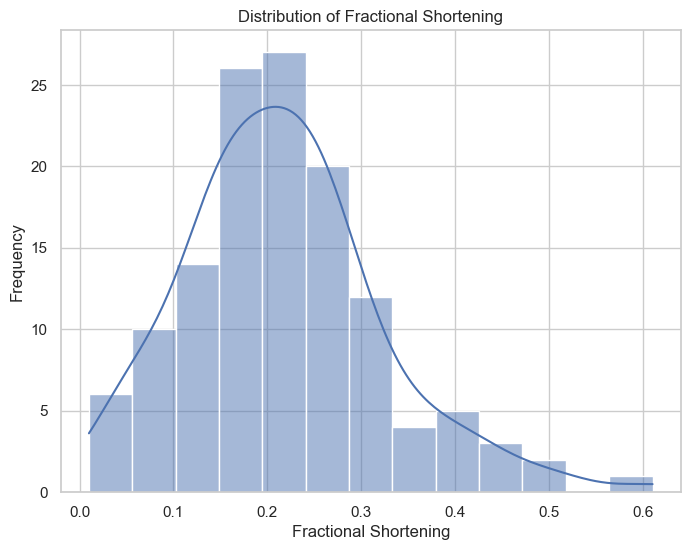

In [118]:
plt.figure(figsize=(8, 6))
sns.histplot(echocardiogram_data_filled['fractional-shortening'], kde=True)
plt.title('Distribution of Fractional Shortening')
plt.xlabel('Fractional Shortening')
plt.ylabel('Frequency')
plt.show()


## Builing new features

A correlation between 'epss' and 'lvdd' was previously noted. To better understand this relationship and improve the dataset's predictive power, we propose creating a new feature: the epss/lvdd ratio.


In [119]:
echocardiogram_data_extended = echocardiogram_data_filled.copy()

echocardiogram_data_extended['epss-lvdd-ratio'] = echocardiogram_data_extended['epss'] / echocardiogram_data_extended['lvdd']


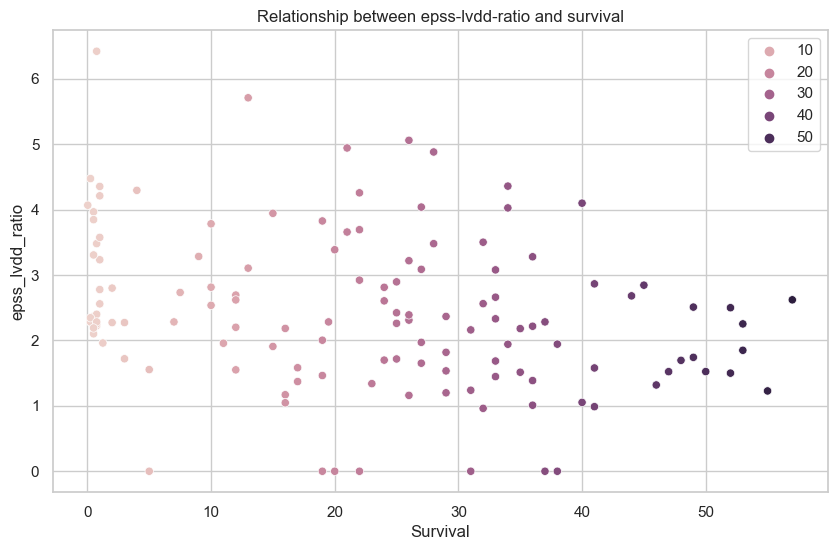

In [120]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=echocardiogram_data_extended, x='survival', y='epss-lvdd-ratio', hue='survival')
plt.title('Relationship between epss-lvdd-ratio and survival')
plt.xlabel('Survival')
plt.ylabel('epss_lvdd_ratio')
plt.legend()
plt.show()


In [121]:
correlation = echocardiogram_data_extended['epss-lvdd-ratio'].corr(echocardiogram_data_extended['survival'])

print("Correlation between epss lvdd ratio and survival:", correlation)


Correlation between epss lvdd ratio and survival: -0.2815089544076766


# Survival analysis

Given that a subject has survived up to a certain point, what is the likelihood that they will experience the event of death within a subsequent short time frame?

In [122]:
echocardiogram_data_filled.count()

survival                 130
still-alive              130
age-at-heart-attack      130
pericardial-effusion     130
fractional-shortening    130
epss                     130
lvdd                     130
wall-motion-score        130
wall-motion-index        130
alive-at-1                73
target                    96
dtype: int64

## Survival

The distribution of the 'survival' variable is close to normal, but there are some exceptions. Notably, there are higher frequencies of values at 0.50, 0.75, and 1 month, which differ from what we would expect in a normal distribution.


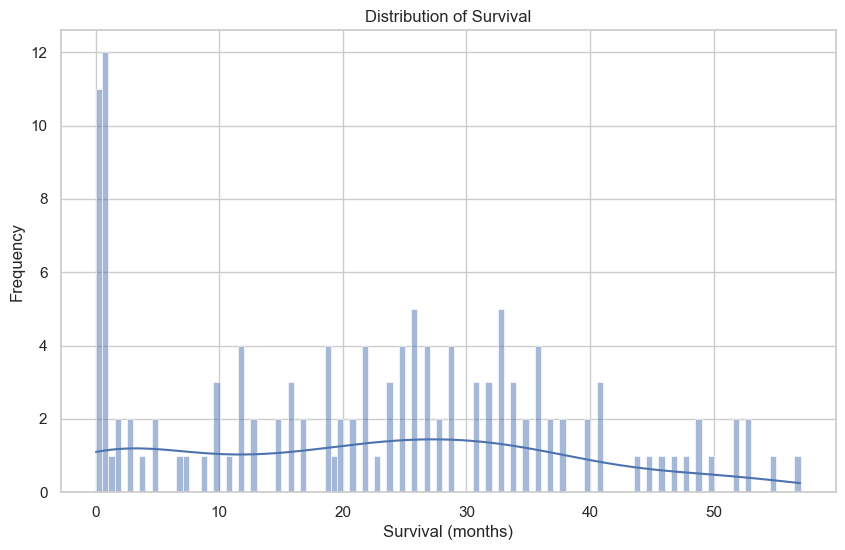

In [123]:
plt.figure(figsize=(10, 6))
sns.histplot(data=echocardiogram_data_filled, x='survival', bins=int(echocardiogram_data_filled['survival'].max() / 0.25), 
                 kde=True, binwidth=0.5)
plt.xlabel('Survival (months)')
plt.ylabel('Frequency')
plt.title('Distribution of Survival')
plt.show()


In [124]:
survival_freq = echocardiogram_data_filled['survival'].value_counts().sort_values(ascending=False)

survival_freq.head(10)


survival
0.50     6
0.75     6
1.00     6
26.00    5
33.00    5
36.00    4
29.00    4
12.00    4
19.00    4
25.00    4
Name: count, dtype: int64

But if we remove right-censored data, we will see that data is normal-distributed. 


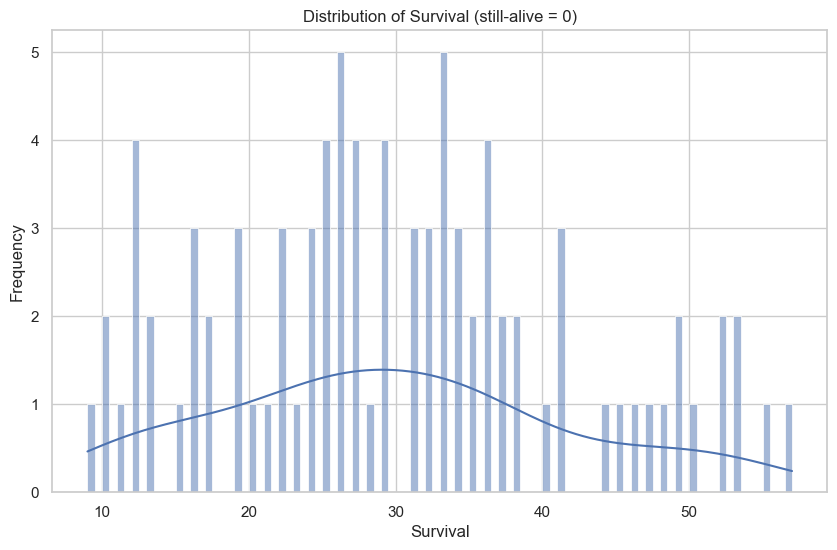

In [125]:
filtered_data = echocardiogram_data_filled[echocardiogram_data_filled['still-alive'] == 0].drop(['alive-at-1'], axis=1)

plt.figure(figsize=(10, 6))

sns.histplot(data=filtered_data, x='survival', bins=int(filtered_data['survival'].max() / 0.25), kde=True, binwidth=0.5)

plt.xlabel('Survival')
plt.ylabel('Frequency')
plt.title('Distribution of Survival (still-alive = 0)')
plt.show()


In [126]:
filtered_data.count()

survival                 88
still-alive              88
age-at-heart-attack      88
pericardial-effusion     88
fractional-shortening    88
epss                     88
lvdd                     88
wall-motion-score        88
wall-motion-index        88
target                   88
dtype: int64

In [127]:
statistic, p_value = shapiro(filtered_data['survival'])

alpha = 0.05
if p_value > alpha:
    print(f"The data resembles a normal distribution (we do not reject the hypothesis). p-value = {p_value:.2}")
else:
    print(f"The data does not resemble a normal distribution (we reject the hypothesis). p-value = {p_value:.2}")
    

The data resembles a normal distribution (we do not reject the hypothesis). p-value = 0.059


## Cox Model


In [128]:
X = echocardiogram_data_filled.drop(columns=['survival', 'alive-at-1', 'target'])
y = echocardiogram_data_filled['survival']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)#, random_state=42)

train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

cph = CoxPHFitter()
cph.fit(train, duration_col='survival', event_col='still-alive', show_progress=True)

cph.print_summary()


Iteration 1: norm_delta = 1.11922, step_size = 0.9500, log_lik = -135.99066, newton_decrement = 19.85005, seconds_since_start = 0.0
Iteration 2: norm_delta = 0.21165, step_size = 0.9500, log_lik = -119.54991, newton_decrement = 1.28505, seconds_since_start = 0.0
Iteration 3: norm_delta = 0.03256, step_size = 0.9500, log_lik = -118.23614, newton_decrement = 0.01967, seconds_since_start = 0.0
Iteration 4: norm_delta = 0.00043, step_size = 1.0000, log_lik = -118.21628, newton_decrement = 0.00001, seconds_since_start = 0.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -118.21627, newton_decrement = 0.00000, seconds_since_start = 0.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 104 total observations, 73 right-censored observations>
             duration col = 'survival'
                event col = 'still-alive'
      baseline estimation = breslow
   number of observations = 104
number of events observed = 31
   partial log-likelihood = -118.22
         time fit was run = 2024-11-16 19:16:27 UTC

---
                        coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                     
age-at-heart-attack     0.08       1.08       0.02             0.03             0.12                 1.03                 1.13
pericardial-effusion    0.63       1.87       0.41            -0.17             1.42                 0.84                 4.15
fractional-shortening  -2.48       0.08       2.09            -6.58             1.62                 0.00                 5.07
epss                    0.04       1.04       0.03            -0.02             0.10                 0.98                 1.10
lvdd                   -0.04       0.96       0.33            -0.69             0.62                 0.50                 1.85
wall-motion-score      -0.05       0.95       0.05            -0.15             0.05                 0.86                 1.05
wall-motion-index       1.82       6.19       0.72             0.42             3.23                 1.52                25.32

                        cmp to     z      p   -log2(p)
covariate                                             
age-at-heart-attack       0.00  3.42 <0.005      10.63
pericardial-effusion      0.00  1.54   0.12       3.03
fractional-shortening     0.00 -1.18   0.24       2.08
epss                      0.00  1.18   0.24       2.06
lvdd                      0.00 -0.11   0.91       0.13
wall-motion-score         0.00 -0.97   0.33       1.59
wall-motion-index         0.00  2.54   0.01       6.49
---
Concordance = 0.80
Partial AIC = 250.43
log-likelihood ratio test = 35.55 on 7 df
-log2(p) of ll-ratio test = 16.79

There are two significant features: 
1. age-at-heart-attack 
2. wall-motion-index 

High Concordance = 0.76

exp(coef) > 1 means that as the value of the trait increases, the risk of death increases for both of them.
Which means that abnormalities in the movement of the wall of the heart significantly increase the risk to the patient, as it does by age at heart attack too. 

In [129]:
scores = cph.score(test, scoring_method="concordance_index")

print(f"Concordance Index: {scores:.2f}")


Concordance Index: 0.70


<Axes: xlabel='log(HR) (95% CI)'>

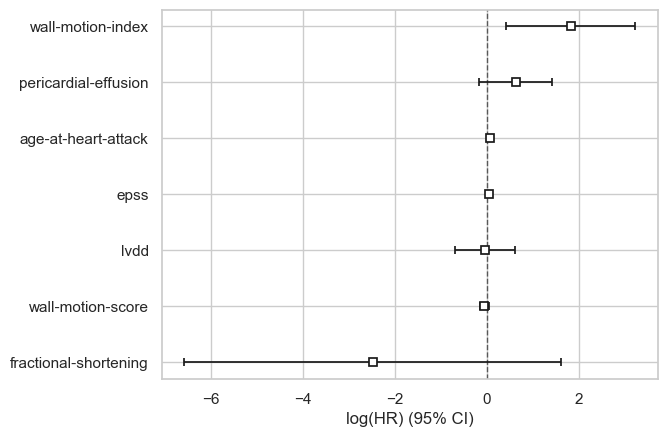

In [130]:
cph.plot()


### Check Cox Proportional-Hazards model assumptions

In [131]:
cph.check_assumptions(train, p_value_threshold=0.05)


Proportional hazard assumption looks okay.


[]

In [132]:
results = proportional_hazard_test(cph, train, time_transform='rank')

results.summary.head()


,test_statistic,p,-log2(p)
age-at-heart-attack,0.145563,0.702812,0.508788
epss,0.021984,0.882131,0.180936
fractional-shortening,1.589180,0.207443,2.269211
lvdd,0.137333,0.710947,0.492186
pericardial-effusion,2.521613,0.112296,3.154626


## Predicted 12-Month Survival Analysis

In [133]:
survival_functions = cph.predict_survival_function(echocardiogram_data_filled)

twelve_month_survival = survival_functions.loc[12].values

echocardiogram_data_filled['prob-survival-12-months'] = twelve_month_survival

echocardiogram_data_filled.head()


,survival,still-alive,age-at-heart-attack,pericardial-effusion,fractional-shortening,epss,lvdd,wall-motion-score,wall-motion-index,alive-at-1,target,prob-survival-12-months
0,11.0,0,71.0,0,0.260,9.000,4.600,14.0,1.00,0.0,0.0,0.881133
1,19.0,0,72.0,0,0.380,6.000,4.100,14.0,1.70,0.0,1.0,0.717570
2,16.0,0,55.0,0,0.260,4.000,3.420,14.0,1.00,0.0,1.0,0.968127
3,57.0,0,60.0,0,0.253,12.062,4.603,16.0,1.45,0.0,1.0,0.880310
4,19.0,1,57.0,0,0.160,22.000,5.750,18.0,2.25,0.0,1.0,0.504673


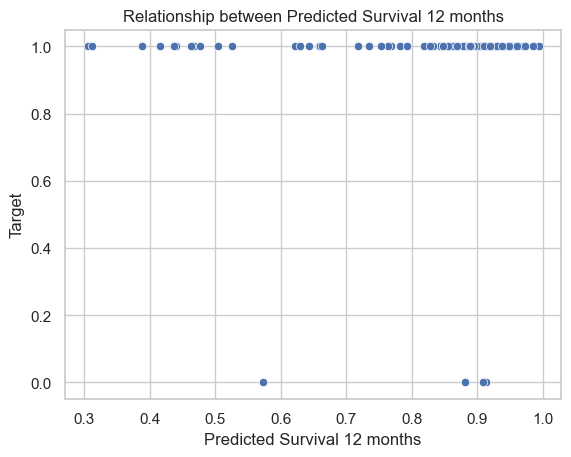

In [134]:
sns.scatterplot(x='prob-survival-12-months', y='target', data=echocardiogram_data_filled)

plt.xlabel('Predicted Survival 12 months')
plt.ylabel('Target')
plt.title('Relationship between Predicted Survival 12 months')

plt.show()


In [135]:
echocardiogram_data_filled.to_csv('result.csv')


## Kaplan-Meier

Text(0, 0.5, 'Survival Probability')

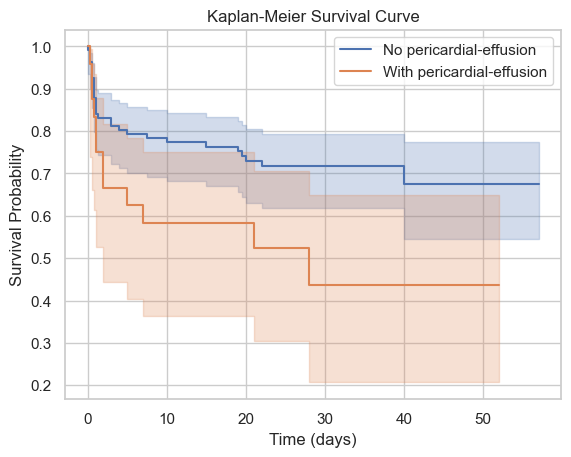

In [136]:
groups = echocardiogram_data_filled['pericardial-effusion']

ix0 = (groups == 0)  # without pericardial-effusion
ix1 = (groups == 1)  # with pericardial-effusion

kmf = KaplanMeierFitter()

kmf.fit(echocardiogram_data_filled[ix0]['survival'], echocardiogram_data_filled[ix0]['still-alive'], label='No pericardial-effusion')
ax = kmf.plot()

kmf.fit(echocardiogram_data_filled[ix1]['survival'], echocardiogram_data_filled[ix1]['still-alive'], label='With pericardial-effusion')
kmf.plot(ax=ax)

ax.set_title('Kaplan-Meier Survival Curve')
ax.set_xlabel('Time (days)')
ax.set_ylabel('Survival Probability')


In [137]:
survival0 = echocardiogram_data_filled[ix0]['survival']
event0 = echocardiogram_data_filled[ix0]['still-alive']

survival1 = echocardiogram_data_filled[ix1]['survival']
event1 = echocardiogram_data_filled[ix1]['still-alive']

results = logrank_test(survival0, survival1, event_observed_A=event0, event_observed_B=event1)

print(f"Log-rank test p-value: {results.p_value}")

if results.p_value < 0.05:
    print("There is a significant difference between the two survival curves.")
else:
    print("There is no significant difference between the two survival curves.")


Log-rank test p-value: 0.031906258555903386
There is a significant difference between the two survival curves.


In [138]:
kmf.fit(survival0, event_observed=event0)
median_no_effusion = kmf.median_survival_time_

kmf.fit(survival1, event_observed=event1)
median_with_effusion = kmf.median_survival_time_

print(f"Median survival time (No pericardial-effusion): {median_no_effusion}")
print(f"Median survival time (With pericardial-effusion): {median_with_effusion}")


Median survival time (No pericardial-effusion): inf
Median survival time (With pericardial-effusion): 28.0
